In [4]:
import csv
import requests
from pyspark.sql import SparkSession

In [2]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
CSV_URL = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=IBM&interval=15min&slice=year1month1&apikey=BMKUL0QPLRBAX5L4'

with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
    csv_file= open('/home/hdoop/python_operation/Stock_Price_Prediction/stockData.csv', 'w')
    csv_writer = csv.writer(csv_file, delimiter=",")
    for row in my_list:
        csv_writer.writerow(row)

In [5]:
spark=SparkSession.builder.appName('StockData').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-03-25 15:04:46,865 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
df = spark.read.csv("file:///home/hdoop/python_operation/Stock_Price_Prediction/stockData.csv", header=True, inferSchema=True)

In [7]:
df.show()

+-------------------+-------+-------+--------+--------+------+
|               time|   open|   high|     low|   close|volume|
+-------------------+-------+-------+--------+--------+------+
|2022-03-23 19:45:00|  128.3|  128.3|   128.3|   128.3|   338|
|2022-03-23 19:30:00| 128.11| 128.11|  128.11|  128.11|   100|
|2022-03-23 17:45:00| 128.15| 128.31|  128.15|   128.3|   400|
|2022-03-23 17:30:00| 128.11| 128.11|  128.11|  128.11|   203|
|2022-03-23 17:00:00| 128.28| 128.28|  128.04|  128.13|  1855|
|2022-03-23 16:30:00| 128.27| 128.27|  128.27|  128.27|   200|
|2022-03-23 16:15:00|  128.3|  128.3|   128.3|   128.3|102926|
|2022-03-23 16:00:00| 128.57| 128.62|  128.25|  128.27|341704|
|2022-03-23 15:45:00| 128.88| 128.88|  128.46|  128.57|127691|
|2022-03-23 15:30:00| 128.89| 128.97|  128.85|   128.9| 62496|
|2022-03-23 15:15:00| 129.09| 129.22| 128.865|128.8797| 70395|
|2022-03-23 15:00:00| 128.83|129.165|  128.78| 129.075|120857|
|2022-03-23 14:45:00| 129.05| 129.06|  128.82|  128.82|

In [8]:
df.printSchema()

root
 |-- time: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)



In [9]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [10]:
df.columns

['time', 'open', 'high', 'low', 'close', 'volume']

In [11]:
feature_cols = ['open','high','low']
vect_assembler = VectorAssembler(inputCols= feature_cols, outputCol='features')

In [12]:
data_w_features = vect_assembler.transform(df)
final_df = data_w_features.select('features','close','time')
final_df.count()
final_df.show(100, truncate=False)

+--------------------------+--------+-------------------+
|features                  |close   |time               |
+--------------------------+--------+-------------------+
|[128.3,128.3,128.3]       |128.3   |2022-03-23 19:45:00|
|[128.11,128.11,128.11]    |128.11  |2022-03-23 19:30:00|
|[128.15,128.31,128.15]    |128.3   |2022-03-23 17:45:00|
|[128.11,128.11,128.11]    |128.11  |2022-03-23 17:30:00|
|[128.28,128.28,128.04]    |128.13  |2022-03-23 17:00:00|
|[128.27,128.27,128.27]    |128.27  |2022-03-23 16:30:00|
|[128.3,128.3,128.3]       |128.3   |2022-03-23 16:15:00|
|[128.57,128.62,128.25]    |128.27  |2022-03-23 16:00:00|
|[128.88,128.88,128.46]    |128.57  |2022-03-23 15:45:00|
|[128.89,128.97,128.85]    |128.9   |2022-03-23 15:30:00|
|[129.09,129.22,128.865]   |128.8797|2022-03-23 15:15:00|
|[128.83,129.165,128.78]   |129.075 |2022-03-23 15:00:00|
|[129.05,129.06,128.82]    |128.82  |2022-03-23 14:45:00|
|[128.89,129.06,128.86]    |129.05  |2022-03-23 14:30:00|
|[128.72,128.9

In [13]:
#train dataset-test dataset
train_dataset, test_dataset = final_df.randomSplit([0.8, 0.2])
train_dataset.describe().show()

+-------+------------------+-------------------+
|summary|             close|               time|
+-------+------------------+-------------------+
|  count|               716|                716|
|   mean|125.10263617318437|               null|
| stddev|2.3900784816424303|               null|
|    min|             119.1|2022-02-22 13:00:00|
|    max|            129.37|2022-03-23 19:45:00|
+-------+------------------+-------------------+



In [14]:
test_dataset.describe().show()

+-------+------------------+-------------------+
|summary|             close|               time|
+-------+------------------+-------------------+
|  count|               174|                174|
|   mean|125.24062126436782|               null|
| stddev|2.5031394096437283|               null|
|    min|           119.435|2022-02-22 13:30:00|
|    max|            137.24|2022-03-23 16:15:00|
+-------+------------------+-------------------+



In [15]:
#importing linear regression module
from pyspark.ml.regression import LinearRegression

LinReg = LinearRegression(featuresCol="features", labelCol="close")

#Train the model on the training using fit() method
model = LinReg.fit(train_dataset)

pred = model.evaluate(test_dataset)

pred.predictions.show(20)

2022-03-25 15:05:48,088 WARN util.Instrumentation: [30ef2183] regParam is zero, which might cause numerical instability and overfitting.
2022-03-25 15:05:48,337 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
2022-03-25 15:05:48,357 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
2022-03-25 15:05:48,559 WARN netlib.InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
/home/hdoop/spark/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+--------+-------------------+------------------+
|            features|   close|               time|        prediction|
+--------------------+--------+-------------------+------------------+
|[119.4,119.45,119.4]|  119.45|2022-02-24 07:45:00|119.45408299706213|
|[119.43,119.47,11...|  119.47|2022-02-24 12:30:00|119.19297555315276|
|[119.71,119.76,11...| 119.435|2022-02-24 12:15:00|119.51994556239669|
| [121.2,121.5,121.2]|   121.5|2022-02-25 07:15:00|121.45665627572734|
|[121.27,121.27,12...|  120.85|2022-03-01 10:45:00|120.85110719633417|
|[121.3,121.38,120...| 120.895|2022-02-24 15:30:00|121.02155978464822|
|[121.3687,121.580...|  121.42|2022-03-01 13:00:00| 121.4587236459615|
|[121.5,121.5975,1...|121.5975|2022-03-02 08:45:00|121.58909729778256|
|[121.505,122.23,1...|  121.88|2022-03-01 15:15:00|122.06827000477264|
|[121.53,121.75,12...|  121.51|2022-02-28 15:15:00|121.57864069417585|
|[121.55,122.02,12...|  121.72|2022-03-01 14:45:00|121.89114407861007|
| [121

/home/hdoop/spark/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


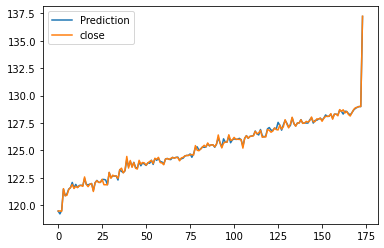

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
panda_df = pred.predictions.toPandas()
plt.plot(panda_df['prediction'])
plt.plot(panda_df['close'])
plt.legend(['Prediction','close'])

In [17]:
#finding out the coefficients

print("The coefficient of the model is : %a" %model.coefficients)
print("The Intercept of the Model is: %f" %model.intercept)

The coefficient of the model is : DenseVector([-0.6121, 0.8245, 0.7856])
The Intercept of the Model is: 0.248847


In [18]:
#finding out various errors

from pyspark.ml.evaluation import RegressionEvaluator 

evaluation = RegressionEvaluator(labelCol="close", predictionCol="prediction")

#Root Mean Square Error
rmse = evaluation.evaluate(pred.predictions, {evaluation.metricName: "rmse"})
print("RMSE: %.3f" % rmse)

#Mean Square Error
mse = evaluation.evaluate(pred.predictions, {evaluation.metricName: "mse"})
print("MSE: %.3f" %mse)

#Mean Absolute Error
mae = evaluation.evaluate(pred.predictions, {evaluation.metricName: "mae"})
print("MAE: %.3f" %mae)

#r2 - coefficient of determination
r2 = evaluation.evaluate(pred.predictions, {evaluation.metricName: "r2"})
print("R-squared(r2): %.3f" %r2)

/home/hdoop/spark/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


RMSE: 0.126
MSE: 0.016
MAE: 0.077
R-squared(r2): 0.997


In [19]:
hdfs_predicted_df = pred.predictions

In [20]:
# saving the trained model to hadoop
model.save("hdfs://localhost:9000/Stock_Prediction/prediction_model")

#saving the test dataset model to hadoop in parquet format for compressed storage
test_dataset.write.parquet("hdfs://localhost:9000/Stock_Prediction/test_datases")

#saving the result dataset on hdfs after testing in parquet format for compressesd storage
hdfs_predicted_df.write.parquet("hdfs://localhost:9000/Stock_Prediction/Clean_Predicted_Data")

#saving the model to local
model.save("/home/hdoop/python_operation/Stock_Price_Prediction")

In [21]:
# saving the trained model to hadoop
model.save("file:///home/hdoop/python_operation/Stock_Price_Prediction/prediction_model")

#saving the test dataset model to hadoop in parquet format for compressed storage
test_dataset.write.parquet("file:///home/hdoop/python_operation/Stock_Price_Prediction/test_datases")

#saving the result dataset on hdfs after testing in parquet format for compressesd storage
hdfs_predicted_df.write.parquet("file:///home/hdoop/python_operation/Stock_Price_Prediction/Clean_Predicted_Data")

#saving the model to local
model.save("file:///home/hdoop/python_operation/Stock_Price_Prediction/model")